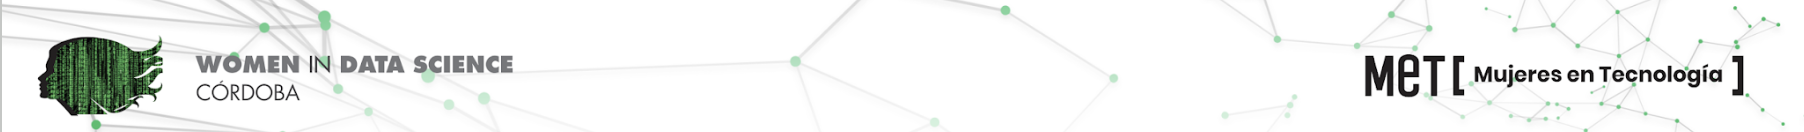

# Model Baseline


-------------------------------

## Librerías

In [20]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
sns.set_style("white")
sns.set_palette("flare")

seed = 42

## 01) Lectura de los datos

In [2]:
%%time
df_test_eda = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS0IbI8WiSzaY-YJnZqQlBvhh7QJ-ynt751CixvxndlMpe0pBNQB0_2xyCkDvV7uh2vEWuqolIj_bQH/pub?gid=731515881&single=true&output=csv')
df_train_eda = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQGoPiS3C4divKxs17LM3mhcG7L-JDXHYcIpX8sNET9wbLctqlS-V4ID0cwVMdEccdt8f6FitC2K0YC/pub?gid=2112906031&single=true&output=csv')
df_train_proc = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSfUNcRvLD7fRUDaMru76eeQ2fELQYvY7XZFhN8BwStMCh6EdlUFdUR31QHTBaVNxJvndM2i0JdNHGc/pub?gid=360615667&single=true&output=csv')
df_test_proc = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTdXFFlsPhb7ZMB_LVUf-LFkfuDpT9ZGYDEAU7SWD9Hg1pzeUuCf_v6u4CSXLihieA0xDhQ32ybfkyD/pub?gid=1667917604&single=true&output=csv')

df_train_proc.head()

CPU times: user 154 ms, sys: 41.7 ms, total: 195 ms
Wall time: 5.64 s


,CustomerID,Dependents,Internet Service_Fiber optic,Monthly Charges,Contract_Two year,Contract_Month-to-month,Online Security_No,Tenure Months,Device Protection_No,Paperless Billing,Payment Method_Electronic check,Internet Service_No,Senior Citizen,Partner,Online Backup_No,Tech Support_No
0,9571-EDEBV,0,1,98.65,0,0,1,71,0,1,0,0,0,1,1,1
1,7562-GSUHK,0,1,93.20,0,1,1,16,0,1,0,0,0,0,0,1
2,2325-WINES,0,1,104.05,0,0,1,32,0,1,0,0,0,0,0,1
3,9381-NDKME,0,0,40.65,0,1,1,24,0,1,0,0,1,1,1,1
4,2164-SOQXL,1,0,20.05,0,1,0,20,0,0,0,1,0,1,0,0


In [3]:
df_train_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CustomerID                       5634 non-null   object 
 1   Dependents                       5634 non-null   int64  
 2   Internet Service_Fiber optic     5634 non-null   int64  
 3   Monthly Charges                  5634 non-null   float64
 4   Contract_Two year                5634 non-null   int64  
 5   Contract_Month-to-month          5634 non-null   int64  
 6   Online Security_No               5634 non-null   int64  
 7   Tenure Months                    5634 non-null   int64  
 8   Device Protection_No             5634 non-null   int64  
 9   Paperless Billing                5634 non-null   int64  
 10  Payment Method_Electronic check  5634 non-null   int64  
 11  Internet Service_No              5634 non-null   int64  
 12  Senior Citizen      

In [22]:
X_train = df_train_proc.copy()
X_train.drop('CustomerID', axis = 1, inplace = True)
Y_train = df_train_eda['Churn Value']

In [5]:
X_test = df_test_proc.copy()
X_test.drop('CustomerID', axis = 1, inplace = True)
Y_test = df_test_eda['Churn Value']

## 02) Benchmarking

In [6]:
# Modelos
log_class = LogisticRegression(C = 0.05)
rf_class = RandomForestClassifier(max_depth = 5,n_estimators=1000, random_state=42)
xgboost_class = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000, random_state=42)
lgbm_class = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000, random_state=42)

In [7]:
# Nombres
models = {'log_reg':log_class,
          'rfc' : rf_class,
          'xgboost' : xgboost_class,
          'lgbm': lgbm_class}

In [8]:
cv = 10
scoring = ['roc_auc', 'f1', 'recall']

In [9]:
def benchmarking_models(models, X, y, cv, scoring):

  df_cv_sum = pd.DataFrame(columns=['Model', 'Metric', 'Mean', 'STD'])
  results = list()

  for name, model in models.items():
    kfold = model_selection.KFold(n_splits = cv, random_state = seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring = scoring)

    row = {
            'Model': name,
            'Metric': scoring,
            'Mean': np.round(cv_results.mean(),3),
            'STD': np.round(cv_results.std(),3)
            }

    df_cv_sum = df_cv_sum.append(row, ignore_index=True)
    results.append(cv_results)

  return df_cv_sum, results

In [10]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[0])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 1min 45s, sys: 2.1 s, total: 1min 48s
Wall time: 1min 29s


,Model,Metric,Mean,STD
2,xgboost,roc_auc,0.86,0.02
3,lgbm,roc_auc,0.86,0.02
0,log_reg,roc_auc,0.85,0.02
1,rfc,roc_auc,0.85,0.02


In [11]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[1])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 1min 38s, sys: 1.28 s, total: 1min 39s
Wall time: 1min 11s


,Model,Metric,Mean,STD
3,lgbm,f1,0.59,0.05
0,log_reg,f1,0.59,0.05
2,xgboost,f1,0.59,0.04
1,rfc,f1,0.55,0.03


In [12]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[2])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 1min 40s, sys: 1.24 s, total: 1min 41s
Wall time: 1min 13s


,Model,Metric,Mean,STD
3,lgbm,recall,0.54,0.04
0,log_reg,recall,0.54,0.04
2,xgboost,recall,0.54,0.04
1,rfc,recall,0.46,0.02


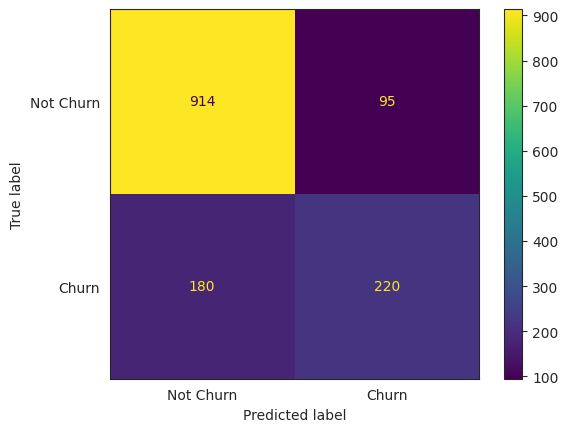

In [23]:
xgboost_class.fit(X_train, Y_train)
cm = confusion_matrix(Y_test, xgboost_class.predict(X_test), labels=xgboost_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Not Churn', 'Churn'])

disp.plot()

#### ¿Qué pasa si incluyo todas las variables?

In [13]:
df_train_full = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRo9qIZZ0SE53K0kKwvjNeaeEzxkK46iG9JPCuyLL16k8Kxru_BHYJwTHyEn8kT4_3r3L6qeqsFvbND/pub?gid=2109885380&single=true&output=csv')

In [14]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 42 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CustomerID                                5634 non-null   object 
 1   Monthly Charges                           5634 non-null   float64
 2   Total Charges                             5634 non-null   float64
 3   Tenure Months                             5634 non-null   int64  
 4   Gender                                    5634 non-null   int64  
 5   Senior Citizen                            5634 non-null   int64  
 6   Partner                                   5634 non-null   int64  
 7   Dependents                                5634 non-null   int64  
 8   Phone Service                             5634 non-null   int64  
 9   Multiple Lines_Yes                        5634 non-null   int64  
 10  Multiple Lines_No                   

In [15]:
X_train = df_train_full.copy()
X_train.drop(['CustomerID', 'Churn Value'], axis = 1, inplace = True)
Y_train = df_train_full['Churn Value']

In [16]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[0])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 2min 51s, sys: 1.51 s, total: 2min 52s
Wall time: 1min 53s


,Model,Metric,Mean,STD
2,xgboost,roc_auc,0.86,0.02
3,lgbm,roc_auc,0.86,0.02
0,log_reg,roc_auc,0.85,0.02
1,rfc,roc_auc,0.85,0.02


In [17]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[1])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 2min 50s, sys: 1.44 s, total: 2min 52s
Wall time: 1min 53s


,Model,Metric,Mean,STD
0,log_reg,f1,0.61,0.04
2,xgboost,f1,0.60,0.04
3,lgbm,f1,0.60,0.05
1,rfc,f1,0.54,0.04


In [18]:
%%time
df_cv_results, results = benchmarking_models(models, X_train, Y_train, cv = 10, scoring = scoring[2])
df_cv_results.sort_values(by = 'Mean', ascending = False)

CPU times: user 2min 52s, sys: 1.47 s, total: 2min 53s
Wall time: 1min 55s


,Model,Metric,Mean,STD
0,log_reg,recall,0.56,0.03
2,xgboost,recall,0.55,0.04
3,lgbm,recall,0.55,0.04
1,rfc,recall,0.44,0.03
